In [1]:
# !pip install bokeh==2.2.2
# !pip install jinja2==2.11.2
# !pip install scikit-learn
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fnmatch import fnmatch
import re
from datetime import datetime,timedelta
from scipy.ndimage import uniform_filter1d

# import bokeh.sampledata
# bokeh.sampledata.download()

from bokeh.io import show , output_notebook
from bokeh.layouts import column, gridplot,layout
from bokeh.models import ColumnDataSource, RangeTool, HoverTool, TapTool, OpenURL,LinearColorMapper, CustomJS
from bokeh.plotting import figure
from bokeh.sampledata.stocks import AAPL
from bokeh.transform import factor_cmap
from bokeh.events import Tap
from bokeh.palettes import Spectral6,gray

plt.rcParams["figure.figsize"] = (20,10)

output_notebook()

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

Loading BokehJS ...

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
# change the metadata (the last column is the loss) path to yours

metadataPath = r"VQVAE3515.csv"  


metadata = pd.read_csv(metadataPath)

metadata.head()

,image,date,boxfgloss,boxbgloss,bigloss
0,20200814_clip_34_1503_image_0000,20200814,0.001497,0.006955,0.006778
1,20200814_clip_34_1503_image_0002,20200814,0.001621,0.006875,0.006769
2,20200814_clip_34_1503_image_0004,20200814,0.001278,0.006853,0.006729
3,20200814_clip_34_1503_image_0006,20200814,0.001036,0.007171,0.006995
4,20200814_clip_34_1503_image_0008,20200814,0.001313,0.006988,0.006883


In [4]:
names=metadata['image']

times = np.empty(shape=(0,3))

for name in names:
    
    if name[9]=='c':
        time = name.split("_")[0]+name.split("_")[3]
    else:
        time=name[0:12]+ "."+ name.split("-")[2][1:].zfill(4)
    times = np.append(times,time)

metadata['time'] = times

metadata.head(10)


,image,date,boxfgloss,boxbgloss,bigloss,time
0,20200814_clip_34_1503_image_0000,20200814,0.001497,0.006955,0.006778,202008141503
1,20200814_clip_34_1503_image_0002,20200814,0.001621,0.006875,0.006769,202008141503
2,20200814_clip_34_1503_image_0004,20200814,0.001278,0.006853,0.006729,202008141503
3,20200814_clip_34_1503_image_0006,20200814,0.001036,0.007171,0.006995,202008141503
4,20200814_clip_34_1503_image_0008,20200814,0.001313,0.006988,0.006883,202008141503
5,20200814_clip_34_1503_image_0010,20200814,0.000841,0.006963,0.006807,202008141503
6,20200814_clip_34_1503_image_0012,20200814,0.001022,0.006997,0.006838,202008141503
7,20200814_clip_34_1503_image_0014,20200814,0.001527,0.006998,0.006918,202008141503
8,20200814_clip_34_1503_image_0016,20200814,0.001057,0.007115,0.006923,202008141503
9,20200814_clip_34_1503_image_0018,20200814,0.001056,0.006911,0.006773,202008141503


In [5]:
selected_columns = metadata[['image','date', 'time', 'boxfgloss','boxbgloss','bigloss']]

npplot=selected_columns.copy()
npplot.sort_values(by=['time'])

npplot.sort_values(by=['time'])

,image,date,time,boxfgloss,boxbgloss,bigloss
0,20200814_clip_34_1503_image_0000,20200814,202008141503,0.001497,0.006955,0.006778
33,20200814_clip_34_1503_image_0066,20200814,202008141503,0.001962,0.007042,0.006955
34,20200814_clip_34_1503_image_0068,20200814,202008141503,0.001808,0.006964,0.006877
35,20200814_clip_34_1503_image_0070,20200814,202008141503,0.001641,0.007104,0.006989
36,20200814_clip_34_1503_image_0072,20200814,202008141503,0.001335,0.007036,0.006887
...,...,...,...,...,...,...
3479,20210416_clip_41_1757_image_0050,20210416,202104161757,0.004283,0.006212,0.006301
3480,20210416_clip_41_1757_image_0052,20210416,202104161757,0.002294,0.006364,0.006261
3481,20210416_clip_41_1757_image_0054,20210416,202104161757,0.002379,0.006336,0.006232
3467,20210416_clip_41_1757_image_0026,20210416,202104161757,0.003412,0.006290,0.006310


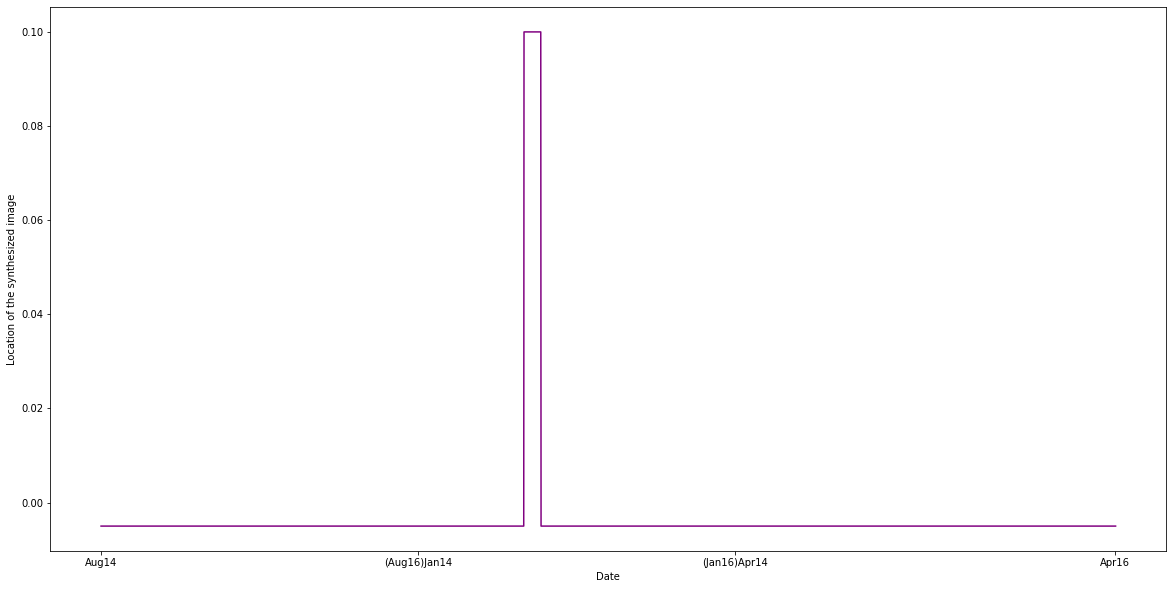

In [6]:
x = np.linspace(start=1, stop=npplot.shape[0], num = npplot.shape[0])

loc = -0.005*np.ones(npplot.shape[0])

loc[1465:1524]=0.1

fig, axes = plt.subplots(nrows=1, ncols=1)
plt.setp(axes, xticks=[0, 1098, 2196, 3514], xticklabels=['Aug14', '(Aug16)Jan14', '(Jan16)Apr14', 'Apr16'])
plt.plot(x, loc,'purple')
plt.xlabel("Date")
plt.ylabel("Location of the synthesized image")
plt.show()

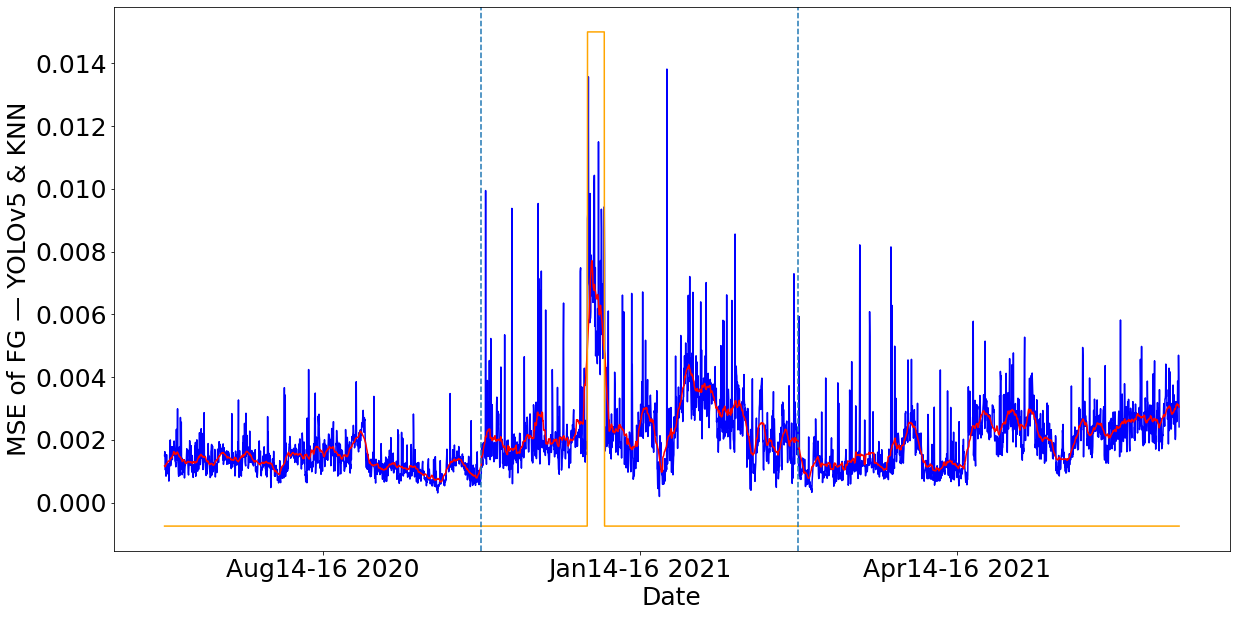

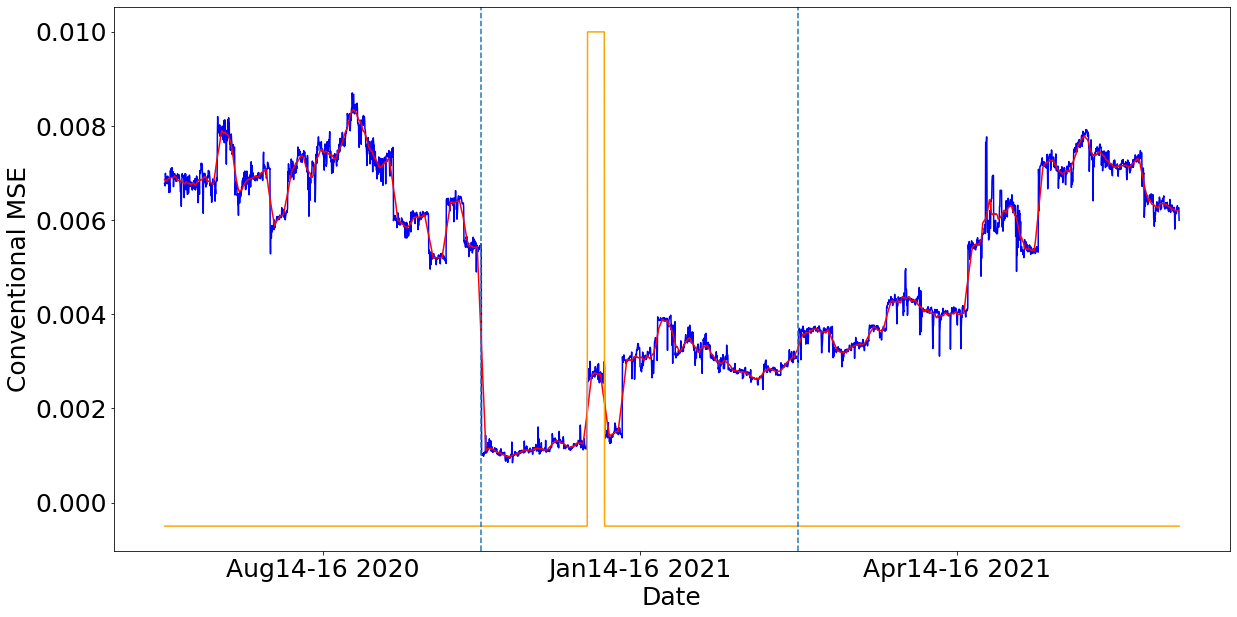

In [7]:
npboxfgloss = npplot['boxfgloss'].to_numpy()
npboxbgloss = npplot['boxbgloss'].to_numpy()
npbigloss = npplot['bigloss'].to_numpy()

filtered_boxfgloss = uniform_filter1d(npboxfgloss, size=30)
filtered_boxbgloss = uniform_filter1d(npboxbgloss, size=30)
filtered_bigloss = uniform_filter1d(npbigloss, size=30)

x = np.linspace(start=1, stop=npplot.shape[0], num = npplot.shape[0])

loc1=loc*0.15

fig, axes = plt.subplots(nrows=1, ncols=1)
plt.setp(axes, xticks=[549, 1647, 2745], xticklabels=['Aug14-16 2020', 'Jan14-16 2021', 'Apr14-16 2021'])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(x, npboxfgloss,'blue', x, filtered_boxfgloss, 'red', x, loc1,'orange')
plt.xlabel("Date",fontsize=25)
plt.ylabel("MSE of FG — YOLOv5 & KNN",fontsize=25)
plt.axvline(x=1098, ls='--')
plt.axvline(x=2196, ls='--')
plt.show()

loc2=loc*0.1

fig, axes = plt.subplots(nrows=1, ncols=1)
plt.setp(axes, xticks=[549, 1647, 2745], xticklabels=['Aug14-16 2020', 'Jan14-16 2021', 'Apr14-16 2021'])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(x, npbigloss,'blue', x, filtered_bigloss, 'red', x, loc2,'orange')
plt.xlabel("Date",fontsize=25)
plt.ylabel("Conventional MSE",fontsize=25)
plt.axvline(x=1098, ls='--')
plt.axvline(x=2196, ls='--')
plt.show()
